## Output Preview

In [ ]:
out = runnable.invoke({
    "input": "Research in detail on the papers of the topic for which author won nobel prize in physics in 2024",
    "chat_history": []
})

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
The Nobel Prize in Physics 2024 was awarded to Geoffrey E. Hinton and John J. Hopfield for their groundbreaking contributions to machine learning. Their work has significantly advanced the field, enabling new technologies and methodologies that have transformed how machines learn and process information.

RESEARCH STEPS
--------------
- Conducted a web search to identify the 2024 Nobel Prize in Physics winners and their contributions.
- Used a RAG search to find relevant papers related to the winners' contributions in machine learning.
- Filtered specific papers to gather detailed insights into their research.
- Retrieved abstracts from ArXiv to understand the high-level context of the papers.

REPORT
---------
Geoffrey E. Hinton, a prominent figure in the field of artificial intelligence, has been recognized for his foundational work in developing machine learning algorithms that mimic human cognitive processes. His research has focused on creating architect

## Code Implemetation

### Pre-requisites

Graph visualization library (not compulsory to use langgraph, used for better understanding of the flow)

In [60]:
!apt-get install graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Pre-requisite python libraries

In [61]:
!pip install -qU --use-deprecated=legacy-resolver \
    datasets==2.19.1 \
    langchain-pinecone==0.1.1 \
    langchain-openai==0.1.9 \
    langchain==0.2.5 \
    langchain-core==0.2.9 \
    langgraph==0.1.1 \
    openai \
    pinecone \
    sentence-transformers==2.2.2 \
    serpapi==0.1.5 \
    google-search-results==2.4.2 \
    pygraphviz==1.12  # for visualizing

Download a dataset which we will be using as the knowledge base for RAG

In [62]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")
dataset

Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'arxiv_id', 'references'],
    num_rows: 209760
})

In [63]:
dataset[0]

{'id': '2401.04088#0',
 'title': 'Mixtral of Experts',
 'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts

### Build knowledge base

Initialize openai and pinecone

In [64]:
from google.colab import userdata
from openai import OpenAI

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
# Set up the OpenAI API client
client = OpenAI(
    api_key=OPENAI_API_KEY,
)

In [65]:
from pinecone import Pinecone, ServerlessSpec
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')

pc = Pinecone(api_key=PINECONE_API_KEY)

spec = ServerlessSpec(
    cloud="aws",
    region="us-east-1"
)

Generate embeddings using openai embedding model

In [66]:
# Use this for openai embeddings

# def generate_embeddings(text_list):
#     response = client.embeddings.create(input=[text_list], model="text-embedding-3-small")
#     return response.data[0].embedding

In [67]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [68]:
def generate_embeddings(text):
    return model.encode(text).tolist()

Get the dimensions of embedding model

In [69]:
dims = len(generate_embeddings("some random text"))
dims

384

Create and Initialize Pinecone index

In [70]:
import time

index_name = "langgraph-research-agent"

# pc.delete_index(index_name)

#check if index already exists
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=dims,
        metric='dotproduct',
        spec=spec
    )
    #wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

#connect to index
index = pc.Index(index_name)
time.sleep(1)
#view index stats
index.describe_index_stats()


{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}

In [71]:
from tqdm.auto import tqdm   #display progress bars in loops

data = dataset.to_pandas().iloc[:10000]

batch_size = 128

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    # creates a list of dict, where each dict represents a row in the df
    batch = data[i:i_end].to_dict(orient="records")

    #get batch of data
    metadata = [{
        "title" : r["title"],
        "content" : r["content"],
        "arxiv_id" : r["arxiv_id"],
        "references" : r["references"].tolist()
    } for r in batch]
    ids = [r["id"] for r in batch]
    #get text content to embed
    content = [r["content"] for r in batch]
    #embed text
    embeds = []
    for t in content:
        embeds.append(generate_embeddings(t))
    #add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))


In [72]:
#view index stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}

### Graph State

In [73]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

### Custom Tools

#### ArXiv Paper Fetch

In [74]:
import requests

#we will test with the mixtral papers

arxiv_id = "2401.04088"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

From all this data we extract Abstract using regex, this is how it looks

```
<blockquote class="abstract mathjax">\n<span class="descriptor">Abstract:</span> We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.\nMixtral has the same architecture as Mistral 7B, with the difference that each\nlayer is composed of 8 feedforward blocks (i.e. experts). For every token, at\neach layer, a router network selects two experts to process the current state\nand combine their outputs. Even though each token only sees two experts, the\nselected experts can be different at each timestep. As a result, each token has\naccess to 47B parameters, but only uses 13B active parameters during inference.\nMixtral was trained with a context size of 32k tokens and it outperforms or\nmatches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,\nMixtral vastly outperforms Llama 2 70B on mathematics, code generation, and\nmultilingual benchmarks. We also provide a model fine-tuned to follow\ninstructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,\nClaude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both\nthe base and instruct models are released under the Apache 2.0 license.\n</blockquote>
```

In [75]:
import re

abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

re_match = abstract_pattern.search(res.text)

print(re_match.group(1))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


Now we pack all of this logic into a tool for our agent to use.

In [76]:
from langchain_core.tools import tool

@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    #get the paper in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    #search html for abstract
    re_match = abstract_pattern.search(res.text)
    #return abstract text
    return re_match.group(1)


Test this tool

In [77]:
print(
    fetch_arxiv.invoke(input={
        "arxiv_id" : arxiv_id
    })
)

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


#### Web Search

Agent will use this tool for more general knowledge queries

In [78]:
from serpapi import GoogleSearch

serpapi_params = {
    "engine" : "google",
    "api_key" : userdata.get('SERPAPI_API_KEY')
}

search = GoogleSearch({
    **serpapi_params,
    "q" : "books"
})

results = search.get_dict()["organic_results"]


In [79]:
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)

In [80]:
print(contexts)

Google Books
Books. Search the world's most comprehensive index of full-text books. My library · PublishersAboutPrivacyTermsHelp.
https://books.google.com/
---
Amazon.com: Books
Best sellers · Arts & Photography · Biographies & Memoirs · Business & Money · Calendars · Children's Books · Comics & Graphic Novels · Computers & Technology.
https://www.amazon.com/books-used-books-textbooks/b?ie=UTF8&node=283155
---
Online Bookstore: Books, NOOK ebooks, Music, Movies ...
Barnes & Noble's online bookstore for books, NOOK ebooks & magazines. Shop music, movies, toys & games, too. Receive free shipping with your Barnes & Noble ...
https://www.barnesandnoble.com/
---
Better World Books: Buy New & Used Books Online
The socially responsible bookstore with cheap new & used books at bargain prices. Quality bookseller with free shipping that donates a book for every book ...
https://www.betterworldbooks.com/?srsltid=AfmBOorCd77FRTbBuRRlqolyieXRbwrmelN-x4t714AV-vENl6UjrDEL
---
Goodreads | Meet your ne

We wrap this into a tool

In [81]:
@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialised query."""
    search = GoogleSearch({
        **serpapi_params,
        "q" : query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]
    contexts =  "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts


### RAG Tools

We provide two RAG-focused tools for our agent. The `rag_search` allows the agent to perform a simple RAG search for some information across _all_ indexed research papers. The `rag_search_filter` also searches, but _within_ a specific paper which is filtered for via the `arxiv_id` parameter.

We also define the `format_rag_contexts` function to handle the transformation of our Pinecone results from a JSON object to a readble plaintext format.

In [82]:
from langchain_core.tools import Tool

def format_rag_contexts(matches: list):
    contexts = []
    for m in matches:
        text = (
            f"Title: {m['metadata']['title']}\n"
            f"Content: {m['metadata']['content']}\n"
            f"ArXiv ID: {m['metadata']['arxiv_id']}\n"
            f"Related Papers: {m['metadata']['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str

@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    emb = generate_embeddings(query)
    res_match = index.query(
        vector=emb,
        top_k=2,
        include_metadata=True,
        filter={
            "arxiv_id" : arxiv_id
        }
    )
    context_str = format_rag_contexts(res_match["matches"])
    return context_str
    return

@tool("rag_search")
def rag_search(query: str):
    """Finds information from our ArXiv database using a natural language query."""
    emb = generate_embeddings(query)
    res_match = index.query(
        vector=emb,
        top_k=2,
        include_metadata=True
    )
    context_str = format_rag_contexts(res_match["matches"])
    return context_str


Test the rag

In [83]:
print(
    rag_search("what is mixtral")
)

Title: Mixtral of Experts
Content: 4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be dif

### Final Answer

In [84]:
@tool("final_answer")
def final_answer(
        introduction: str,
        research_steps: str,
        main_body: str,
        conclusion: str,
        sources: str
):

    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"{i}. {r}" for i, r in enumerate(research_steps)])
    if type(sources) is list:
        sources = "\n".join([f"- {r}" for r in sources])
    return ""

### Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). **Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).**

In [85]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}")
])

#scratchpad is where we will put all the intermediate steps ai will take to resolve user query


Next, we must initialize our `llm` (for this we use `gpt-4o`) and then create the _runnable_ pipeline of our Oracle.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

In [86]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=OPENAI_API_KEY,
    temperature=0,
)

tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

def create_scratchpad(intermediate_steps: list[AgentAction]):
    """
    The primary goal of this function is to transform the intermediate_steps
    (a list of AgentAction objects that store tool execution details) into a
    human-readable string called scratchpad. This scratchpad provides a summary
    of what the agent has done so far.
    """

    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            research_steps.append(
                f"Tool: {action.tool}, Input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        )
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)
# tool_choice="any" forces the LLM to use at least one tool before returning.


Test the agent to confirm it is functional

In [87]:
inputs = {
    "input": "tell me something boring about cats",
    "chat_history": [],
    "intermediate_steps": []
}

out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KCVsRNCHXU3V8ZfIcGeWUNqT', 'function': {'arguments': '{"query":"boring facts about cats"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 542, 'total_tokens': 560, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6b68a8204b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-98d2f6fc-ea81-4094-93d2-c00e77367078-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'boring facts about cats'}, 'id': 'call_KCVsRNCHXU3V8ZfIcGeWUNqT'}], usage_metadata={'input_tokens': 542, 'output_tokens': 18, 'total_tokens': 560})

It is running but we are returning a lot of output here, we can narrow this down to what we need — ie, the chosen tool name and generated input args for the tool.

In [88]:
out.tool_calls[0]['name']

'web_search'

In [89]:
out.tool_calls[0]["args"]

{'query': 'boring facts about cats'}

We can see now that our Oracle decided to use the `web_search` tool with a `query` of `"boring facts about cats"` — a good choice.

### Define Nodes for Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [90]:
def run_oracle(state: list):
    """
    This function is to determine the next action for the research agent to
    take. It does this by invoking the "Oracle" LLM, which is designed to make
    decisions about which tool to use based on the current state of the
    research process.
    """

    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")

    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps" : [action_out]
    }

def router(state: list):
    #return tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to the final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [91]:
tool_str_to_funct = {
    "rag_search_filter" : rag_search_filter,
    "rag_search" : rag_search,
    "fetch_arxiv" : fetch_arxiv,
    "web_search" : web_search,
    "final_answer" : final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    #run tool
    out = tool_str_to_funct[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=out    # output of the tool is logged
    )
    return {"intermediate_steps" : [action_out]}

### Define Graph

In [92]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search_filter", run_tool)
graph.add_node("rag_search", run_tool)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path = router, #function to determine which node is called
)

# create edges from each tool back to oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(
            tool_obj.name, "oracle"
        )

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer",END)

runnable = graph.compile()


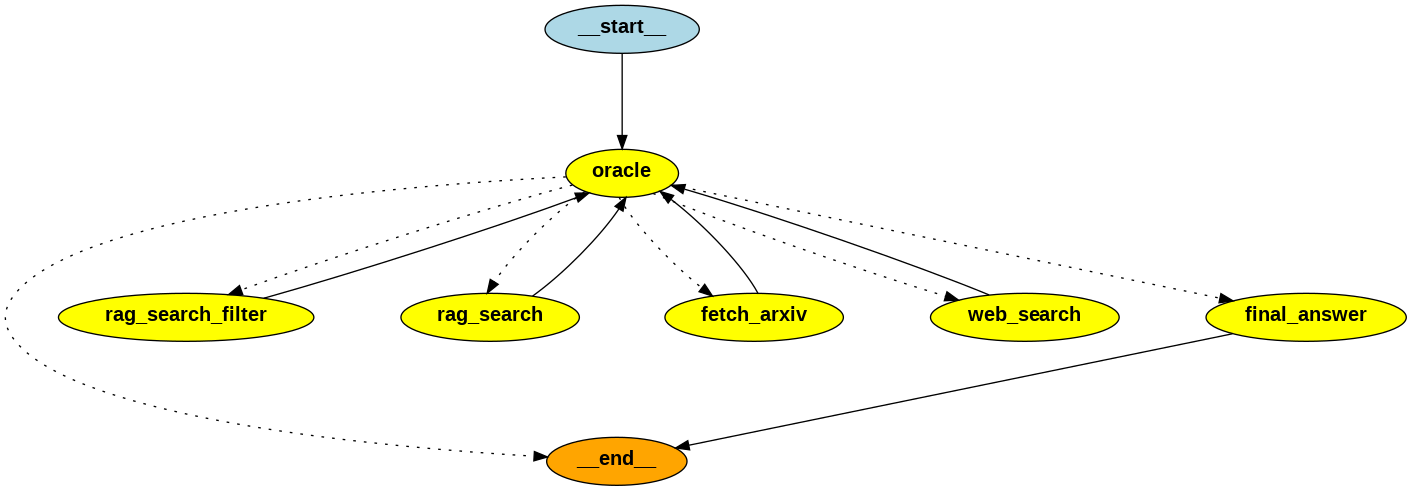

In [93]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

### Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [94]:
out = runnable.invoke({
    "input" : "tell me something boring about cats",
    "chat_history" : [],
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'boring facts about cats'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'boring facts about cats'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'boring facts about cats'}, log="101 Amazing Cat Facts: Fun Trivia About Your Feline Friend\nCats walk like camels and giraffes: They move both of their right feet first, then move both of their left feet. No other animals walk this way.\nhttps://cvillecatcare.com/veterinary-topics/101-amazing-cat-facts-fun-trivia-about-your-feline-friend/\n---\n22 Mind-Blowing Facts about Cats: Feline Fun Trivia\n22 Fun and interesting facts about cats · 11. A house cat can reach speeds of up to 30mph · 12. The oldest cat in the world was 38 years old!\nhttps://www.purina.co.uk/articles/cats/behaviour/common-questions/fun-facts-about-cats\n---\n50 Cat Facts You Probably Didn't Know\nCats are actually more popular in the United States 

Let's create a function to consume the agent output and format it into our report:

In [95]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
---------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [96]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Cats are fascinating creatures, often adored for their playful and mysterious nature. However, not every fact about them is as exciting as their antics might suggest. Let's explore some of the more mundane aspects of our feline friends.

RESEARCH STEPS
--------------
- Conducted a web search for boring facts about cats.
- Reviewed various sources to find less exciting trivia about cats.
- Compiled information to present a balanced view of mundane cat facts.

REPORT
---------
While cats are often associated with agility and grace, one of the more mundane facts about them is their unique walking pattern. Cats walk by moving both of their right feet first, followed by both of their left feet. This gait is shared only with camels and giraffes, making it a peculiar but not particularly thrilling fact.

Another less exciting aspect of cats is their inability to taste sweetness. Unlike humans, cats lack the taste receptors for sweet flavors, which might explain thei

In [97]:
out = runnable.invoke({
    "input" : "tell me about AI",
    "chat_history" : [],
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'AI overview'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'AI overview'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'AI overview'}, log="Google I/O 2024: New generative AI experiences in Search\nWe're bringing AI Overviews to everyone in the U.S. and adding new gen AI experiences to take more of the legwork out of searching.\nhttps://blog.google/products/search/generative-ai-google-search-may-2024/\n---\nAI Overviews and Your Website | Google Search Central\nAI Overviews can help users find your website. Learn more about what AI overviews are, how to control them, and how they can work for your site.\nhttps://developers.google.com/search/docs/appearance/ai-overviews\n---\nFind information in faster & easier ways with AI Overviews ...\nAI Overviews can take the work out of searching by providing an AI-generated snapshot with key information and links to dig

In [98]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Artificial Intelligence (AI) is a rapidly evolving field that aims to create machines capable of performing tasks that typically require human intelligence. This includes a wide range of applications from simple automation to complex decision-making processes.

RESEARCH STEPS
--------------
- Conducted a web search to gather general information about AI and its applications.
- Used a research tool to find academic papers related to AI, focusing on large language models and AI agents.
- Retrieved abstracts from specific ArXiv papers to understand the current research trends in AI.

REPORT
---------
AI has become an integral part of modern technology, influencing various sectors such as healthcare, finance, and entertainment. It encompasses a broad spectrum of technologies, including machine learning, natural language processing, and robotics. AI systems are designed to mimic human cognitive functions such as learning, problem-solving, and decision-making.

One

Let's ask about RAG specifically.

In [99]:
out = runnable.invoke({
    "input": "what is retrieval augmented generation?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'retrieval augmented generation'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log="Title: Large Language Models for Information Retrieval: A Survey\nContent: RECOMP: improving retrieval-augmented lms with compression and selec- tive augmentation,â CoRR, vol. abs/2310.04408, 2023. Jiang, M. R. Parvez, and G. Neubig, â Learning to filter context for retrieval- augmented generation,â CoRR, vol. abs/2311.08377, 2023. [194] J. Liu, L. Li, T. Xiang, B. Wang, and Y. Qian, â\nArXiv ID: 2308.07107\nRelated Papers: ['2305.03195']\n\n---\nTitle: TPTU: Large Language Model-based AI Agents for Task Planning and Tool Usage\nContent: Retrieval-augmented generation for knowledge-intensive nlp tasks,â Advances in Neural Information Processing Systems, vol. 33, pp.

In [100]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Retrieval-Augmented Generation (RAG) is an advanced AI framework designed to enhance the capabilities of generative models by integrating them with external knowledge sources. This approach aims to improve the accuracy and reliability of AI-generated content by grounding it in authoritative information.

RESEARCH STEPS
--------------
- Conducted a search in the ArXiv database to find academic papers related to retrieval-augmented generation.
- Filtered results to focus on specific papers discussing the application and improvements of RAG.
- Performed a web search to gather general knowledge and definitions from reputable sources like AWS, NVIDIA, and Google Cloud.

REPORT
---------
Retrieval-Augmented Generation (RAG) is a technique that combines the strengths of large language models (LLMs) with external knowledge bases to produce more accurate and contextually relevant outputs. The core idea behind RAG is to enhance the generative capabilities of AI models 

In [101]:
out = runnable.invoke({
    "input": "Give detailed analysis on Chain of Thought, go through specific papers if need be?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'Chain of Thought in AI'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Chain of Thought in AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Chain of Thought in AI'}, log="Title: Algorithm of Thoughts: Enhancing Exploration of Ideas in Large Language Models\nContent: Chain- of-Thought Prompting Elicits Reasoning in Large Language Models. Advances in Neural Information Processing Sys- tems, 35: 24824â 24837. Wu, C.-J.; Raghavendra, R.; Gupta, U.; Acun, B.; Ardalani, N.; Maeng, K.; Chang, G.; Aga, F.; Huang, J.; Bai, C.; et al. 2022. Sustainable ai:\nArXiv ID: 2308.10379\nRelated Papers: ['2204.02311']\n\n---\nTitle: The Rise and Potential of Large Language Model Based Agents: A Survey\nContent: Essentials of Artificial Intelligence. Morgan Kaufmann, 1993. [58] Wilkins, D. E. Practical planning - extending the classical AI planning paradigm. Morgan Kaufmann se

In [102]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
The concept of 'Chain of Thought' in artificial intelligence (AI) refers to the ability of AI models, particularly large language models (LLMs), to perform reasoning tasks by simulating a sequence of logical steps. This approach has gained significant attention as it enhances the reasoning capabilities of AI systems, allowing them to tackle complex problems more effectively.

RESEARCH STEPS
--------------
- Conducted a RAG search to identify relevant papers on 'Chain of Thought' in AI.
- Retrieved specific papers and abstracts using their ArXiv IDs for detailed insights.
- Analyzed the content of these papers to understand the advancements and methodologies related to Chain of Thought.

REPORT
---------
The 'Chain of Thought' methodology in AI is primarily focused on enhancing the reasoning capabilities of large language models. One of the key papers in this domain is 'Algorithm of Thoughts: Enhancing Exploration of Ideas in Large Language Models' (ArXiv ID: 

In [104]:
out = runnable.invoke({
    "input": "Research in detail on the papers of the topic for which author won nobel prize in physics in 2024",
    "chat_history": []
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'Nobel Prize in Physics 2024 winner'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'Nobel Prize in Physics 2024 winner'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'Nobel Prize in Physics 2024 winner'}, log='Press release: The Nobel Prize in Physics 2024\nGeoffrey E. Hinton, born 1947 in London, UK. PhD 1978 from The University of Edinburgh, UK. Professor at University of Toronto, Canada. Prize ...\nhttps://www.nobelprize.org/prizes/physics/2024/press-release/\n---\nNobel Prize in Physics\nThe Nobel Prize in Physics 2024 was awarded to John J. Hopfield and Geoffrey E. Hinton “for foundational discoveries and inventions that enable machine learning ...\nhttps://www.nobelprize.org/prizes/physics/')]
rag_search.invoke(input={'query': 'foundational discoveries and inventions that enable machine learning'})
run_oracle
intermediate_steps: [AgentAction(tool='web_se

In [105]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
The Nobel Prize in Physics 2024 was awarded to Geoffrey E. Hinton and John J. Hopfield for their groundbreaking contributions to machine learning. Their work has significantly advanced the field, enabling new technologies and methodologies that have transformed how machines learn and process information.

RESEARCH STEPS
--------------
- Conducted a web search to identify the 2024 Nobel Prize in Physics winners and their contributions.
- Used a RAG search to find relevant papers related to the winners' contributions in machine learning.
- Filtered specific papers to gather detailed insights into their research.
- Retrieved abstracts from ArXiv to understand the high-level context of the papers.

REPORT
---------
Geoffrey E. Hinton, a prominent figure in the field of artificial intelligence, has been recognized for his foundational work in developing machine learning algorithms that mimic human cognitive processes. His research has focused on creating architect